Preprocessing Anime dataset from Kaggle

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import re
import string
import itertools
import statistics

1. Data preprocessing

1.1 Data Cleaning

Anime data

In [2]:
anime_df = pd.read_csv("datasets/animes.csv")

anime_df.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


Missing values + duplicate data for animes.csv

In [3]:
missing_value = pd.DataFrame({
    'Missing Value': anime_df.isnull().sum()
})
display(missing_value)

,Missing Value
uid,0
title,0
synopsis,975
genre,0
aired,0
episodes,706
members,0
popularity,0
ranked,3212
score,579


In [4]:
duplicate = anime_df.duplicated(subset=['title']).sum()
print('There are {} duplicated rows in anime_df'.format(duplicate))

There are 3097 duplicated rows in anime_df


In [5]:
# remove unwanted features (columns) from the dataset
anime_df.rename(columns={'title': 'name'}, inplace=True)
anime_df.drop(['synopsis', 'aired', 'ranked', 'img_url', 'link'], axis=1, inplace=True)

#removing unwanted characters from the anime name strings
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'Â°', '',text)

    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)
anime_df.head(5)

,uid,name,genre,episodes,members,popularity,score
0,28891,Haikyuu Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [6]:
anime_df.rename(columns={'uid': 'anime_id', 'score': 'rating'}, inplace=True)
anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

anime_df.drop_duplicates(subset=['name'], inplace=True)
anime_df.dropna(inplace=True)
anime_df.reset_index(drop=True, inplace=True)

anime_df.head(5)

,anime_id,name,genre,episodes,members,popularity,rating
0,28891,Haikyuu Second Season,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,"['Drama', 'Music', 'Romance', 'School', 'Shoun...",22.0,995473,28,8.83
2,34599,Made in Abyss,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"['Action', 'Military', 'Adventure', 'Comedy', ...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,"['Action', 'Mystery', 'Supernatural', 'Vampire']",1.0,214621,502,8.83


In [7]:
# replace the characters "[]'" with an empty space as the genre column is already of type string
anime_df['genre'] = anime_df['genre'].str.replace("'", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("[", "", regex=False)
anime_df['genre'] = anime_df['genre'].str.replace("]", "", regex=False)

anime_df.head(5)

,anime_id,name,genre,episodes,members,popularity,rating
0,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82
1,23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83
2,34599,Made in Abyss,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83
3,5114,Fullmetal Alchemist Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23
4,31758,Kizumonogatari III Reiketsuhen,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83


Ratings data

In [8]:
user_ratings_df = pd.read_csv("datasets/reviews.csv")

user_ratings_df.head()

,uid,profile,anime_uid,text,score,scores,link
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938
1,259117,baekbeans,34599,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=259117
2,253664,skrn,28891,\n \n \n \n ...,7,"{'Overall': '7', 'Story': '7', 'Animation': '9...",https://myanimelist.net/reviews.php?id=253664
3,8254,edgewalker00,2904,\n \n \n \n ...,9,"{'Overall': '9', 'Story': '9', 'Animation': '9...",https://myanimelist.net/reviews.php?id=8254
4,291149,aManOfCulture99,4181,\n \n \n \n ...,10,"{'Overall': '10', 'Story': '10', 'Animation': ...",https://myanimelist.net/reviews.php?id=291149


Missing values + duplicate data for animes.csv

In [9]:
missing_value = pd.DataFrame({
    'Missing Value': user_ratings_df.isnull().sum()
})
display(missing_value)

,Missing Value
uid,0
profile,0
anime_uid,0
text,0
score,0
scores,0
link,0


In [10]:
user_ratings_df.drop(['link', 'text'], axis=1, inplace=True)
user_ratings_df.rename(columns={'profile': 'user_id'}, inplace=True)

user_ratings_df.user_id = pd.factorize(user_ratings_df.user_id)[0]

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"{'Overall': '8', 'Story': '8', 'Animation': '8..."
1,259117,1,34599,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."
2,253664,2,28891,7,"{'Overall': '7', 'Story': '7', 'Animation': '9..."
3,8254,3,2904,9,"{'Overall': '9', 'Story': '9', 'Animation': '9..."
4,291149,4,4181,10,"{'Overall': '10', 'Story': '10', 'Animation': ..."


In [11]:
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("'", "", regex=False)
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("{", "", regex=False)
user_ratings_df['scores'] = user_ratings_df['scores'].str.replace("}", "", regex=False)

user_ratings_df.head()

,uid,user_id,anime_uid,score,scores
0,255938,0,34096,8,"Overall: 8, Story: 8, Animation: 8, Sound: 10,..."
1,259117,1,34599,10,"Overall: 10, Story: 10, Animation: 10, Sound: ..."
2,253664,2,28891,7,"Overall: 7, Story: 7, Animation: 9, Sound: 8, ..."
3,8254,3,2904,9,"Overall: 9, Story: 9, Animation: 9, Sound: 10,..."
4,291149,4,4181,10,"Overall: 10, Story: 10, Animation: 8, Sound: 9..."


In [12]:
user_ratings_df['scores'] = [re.sub("[^0-9,]", "", anime) for anime in user_ratings_df['scores']]
user_ratings_df.rename(columns={"anime_uid": "anime_id"}, inplace=True)

user_ratings_df.head()

,uid,user_id,anime_id,score,scores
0,255938,0,34096,8,"8,8,8,10,9,8"
1,259117,1,34599,10,"10,10,10,10,10,10"
2,253664,2,28891,7,"7,7,9,8,8,8"
3,8254,3,2904,9,"9,9,9,10,10,9"
4,291149,4,4181,10,"10,10,8,9,10,10"


In [13]:
category_ratings_df = user_ratings_df['scores'].str.split(",", expand=True)
category_ratings_df.columns = ['Overall', 'Story', 'Animation','Sound', 'Character', 'Enjoyment']

category_ratings_df.head(10)

,Overall,Story,Animation,Sound,Character,Enjoyment
0,8,8,8,10,9,8
1,10,10,10,10,10,10
2,7,7,9,8,8,8
3,9,9,9,10,10,9
4,10,10,8,9,10,10
5,10,9,10,10,10,10
6,6,6,9,8,6,6
7,8,7,9,0,0,9
8,10,10,9,10,10,10
9,4,8,9,8,5,4


Finalised user_ratings_df

In [14]:
user_ratings_df = pd.concat([user_ratings_df, category_ratings_df], axis=1)
user_ratings_df.drop(columns=['score', 'scores', 'uid'], inplace=True)

user_ratings_df.head()

,user_id,anime_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,0,34096,8,8,8,10,9,8
1,1,34599,10,10,10,10,10,10
2,2,28891,7,7,9,8,8,8
3,3,2904,9,9,9,10,10,9
4,4,4181,10,10,8,9,10,10


In [15]:
user_ratings_df[['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']] = user_ratings_df[
    ['Overall', 'Story', 'Animation', 'Sound', 'Character', 'Enjoyment']].apply(pd.to_numeric)
    

In [16]:
duplicate = user_ratings_df.duplicated(subset=['user_id', 'anime_id']).sum()
print('There are {} duplicated rows in user_ratings_df'.format(duplicate))

There are 61593 duplicated rows in user_ratings_df


In [17]:
user_ratings_df.drop_duplicates(subset=['user_id', 'anime_id'], inplace=True)

duplicate = user_ratings_df.duplicated(subset=['user_id', 'anime_id']).sum()
print('There are {} duplicated rows in user_ratings_df'.format(duplicate))

There are 0 duplicated rows in user_ratings_df


Merging the anime and ratings dataframes

In [18]:
anime_with_ratings_df = pd.merge(anime_df, user_ratings_df, on='anime_id')

anime_with_ratings_df.drop_duplicates(subset=['user_id', 'name'], inplace=True)
anime_with_ratings_df.reset_index(drop=True, inplace=True)

anime_with_ratings_df.head()

,anime_id,name,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,10,9,9,10,10
2,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,10,9,9,10,10
3,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,7,7,9,0,6
4,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,7,7,9,8,9


Content based filtering recommendation

In [19]:
# use MinMax normalisation to normalise the values of each feature, multiplied by their 
# corresponding weight
normalised_anime_df = anime_df.copy()

weights = {
    'genre': 0.3,
    'members_norm': 0.1,
    'rating_norm': 0.4,
    'popularity_norm': 0.1,
    'episodes_norm': 0.1
}

members_min_val = normalised_anime_df['members'].min()
members_max_val = normalised_anime_df['members'].max()

ratings_min_val = normalised_anime_df['rating'].min()
ratings_max_val = normalised_anime_df['rating'].max()

popularity_min_val = normalised_anime_df['popularity'].min()
popularity_max_val = normalised_anime_df['popularity'].max()

episodes_min_val = normalised_anime_df['episodes'].min()
episodes_max_val = normalised_anime_df['episodes'].max()

normalised_anime_df['members_norm'] = (normalised_anime_df['members'] - members_min_val) / (members_max_val - members_min_val) * weights['members_norm']
normalised_anime_df['avg_rating_norm'] = (normalised_anime_df['rating'] - ratings_min_val) / (ratings_max_val - ratings_min_val) * weights['rating_norm']
normalised_anime_df['popularity_norm'] = (normalised_anime_df['popularity'] - popularity_min_val) / (popularity_max_val - popularity_min_val) * weights['popularity_norm']
normalised_anime_df['episodes_norm'] = (normalised_anime_df['episodes'] - episodes_min_val) / (episodes_max_val - episodes_min_val) * weights['episodes_norm']

normalised_anime_df.head()

,anime_id,name,genre,episodes,members,popularity,rating,members_norm,avg_rating_norm,popularity_norm,episodes_norm
0,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,0.026182,0.377626,0.000858,0.000785
1,23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",22.0,995473,28,8.83,0.053204,0.378172,0.000165,0.000687
2,34599,Made in Abyss,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",13.0,581663,98,8.83,0.031087,0.378172,0.000594,0.000393
3,5114,Fullmetal Alchemist Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",64.0,1615084,4,9.23,0.086320,0.400000,0.000018,0.002062
4,31758,Kizumonogatari III Reiketsuhen,"Action, Mystery, Supernatural, Vampire",1.0,214621,502,8.83,0.011469,0.378172,0.003070,0.000000


In [20]:
normalised_anime_df.drop(['members', 'rating', 'popularity', 'episodes'], axis=1, inplace=True)

normalised_anime_df.head()

,anime_id,name,genre,members_norm,avg_rating_norm,popularity_norm,episodes_norm
0,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",0.026182,0.377626,0.000858,0.000785
1,23273,Shigatsu wa Kimi no Uso,"Drama, Music, Romance, School, Shounen",0.053204,0.378172,0.000165,0.000687
2,34599,Made in Abyss,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",0.031087,0.378172,0.000594,0.000393
3,5114,Fullmetal Alchemist Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",0.086320,0.400000,0.000018,0.002062
4,31758,Kizumonogatari III Reiketsuhen,"Action, Mystery, Supernatural, Vampire",0.011469,0.378172,0.003070,0.000000


In [21]:
genres_df = anime_df['genre'].str.get_dummies(sep=', ').astype(int)
genres_df = genres_df.apply(lambda x : x * weights['genre'])

genres_df.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,0.0,0.0,0.0,0.3,0.0,0.0,0.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.3,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.3,0.3,0.0,0.3,0.0,0.0,0.3,0.0,0.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.0


In [22]:
normalised_anime_df.drop('genre', axis=1, inplace=True)
normalised_anime_df = pd.concat([normalised_anime_df, genres_df], axis=1)

normalised_anime_df.head()

,anime_id,name,members_norm,avg_rating_norm,popularity_norm,episodes_norm,Action,Adventure,Cars,Comedy,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,28891,Haikyuu Second Season,0.026182,0.377626,0.000858,0.000785,0.0,0.0,0.0,0.3,...,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0
1,23273,Shigatsu wa Kimi no Uso,0.053204,0.378172,0.000165,0.000687,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34599,Made in Abyss,0.031087,0.378172,0.000594,0.000393,0.0,0.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5114,Fullmetal Alchemist Brotherhood,0.086320,0.400000,0.000018,0.002062,0.3,0.3,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31758,Kizumonogatari III Reiketsuhen,0.011469,0.378172,0.003070,0.000000,0.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.0


Recommend one season of a show.

E.g. if the recommendations have "Tokyo ghoul season 1, tokyo ghoul season 2" etc. we want to only recommend one of these.

Recommend the one with the highest average rating

In [23]:
def get_unique_recommendations(anime_titles, anime_df=anime_df):
    titles = anime_titles[:]

    # sort all the anime titles so that it is easier to group similar titles
    titles.sort()
    iterator = itertools.groupby(titles, lambda string: string.split(' ')[0])

    grouped_titles = []
    for element, group in iterator:
        grouped_titles.append(list(group))

    # checking for each grouped anime title which one has the highest average rating so that we can recommend
    # that one to the user
    unique_titles = []
    title = ''
    for anime_group in grouped_titles:
        max_rating = 0
        for anime in anime_group:
            anime_index = anime_df[anime_df['name'] == anime].index
            curr_rating = anime_df['rating'].iloc[anime_index[0]]

            if curr_rating > max_rating:
                max_rating = anime_df['rating'].iloc[anime_index[0]]
                title = anime_df['name'].iloc[anime_index[0]]

        unique_titles.append(title)

    return unique_titles

Content-based filtering -> Cosine Similarity

In [24]:
features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()

cosine_sim = cosine_similarity(normalised_anime_df[features], normalised_anime_df[features])

print(cosine_sim)

[[1.         0.69664544 0.39354573 ... 0.44250283 0.3517177  0.67996923]
 [0.69664544 1.         0.39445863 ... 0.24870098 0.35161999 0.67912311]
 [0.39354573 0.39445863 1.         ... 0.24894376 0.35204223 0.3636987 ]
 ...
 [0.44250283 0.24870098 0.24894376 ... 1.         0.36395372 0.61637792]
 [0.3517177  0.35161999 0.35204223 ... 0.36395372 1.         0.30011441]
 [0.67996923 0.67912311 0.3636987  ... 0.61637792 0.30011441 1.        ]]


In [25]:
indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

In [26]:
def content_based_recommendations(title, cosine_sim=cosine_sim, anime_df=anime_df, indices=indices, n_recommendations=50):
    # Get the index of the anime that matches the title
    index = indices[title]
    
    # Get the pairwise cosine similarity scores for all anime with that index
    sim_scores = list(enumerate(cosine_sim[index]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 100 most similar anime -> allows us to have more anime so that we are 
    # still able to recommend n_recommendations animes to the user after getting all the unique titles
    sim_scores = sim_scores[1:101]

    # Get the titles of the top 10 most similar anime
    anime_indices = [i[0] for i in sim_scores]
    
    anime_titles = anime_df['name'].iloc[anime_indices].values.tolist()

    # convert to set for constant lookup time
    unique_titles = set(get_unique_recommendations(anime_titles))

    recommendations = [i for i in anime_titles if i in unique_titles]

    return recommendations[:n_recommendations+1]

In [27]:
content_based_recommendations('Death Note')

['Mirai Nikki',
 'B The Beginning',
 'Higurashi no Naku Koro ni Kai',
 'Mousou Dairinin',
 'Imawa no Kuni no Alice OVA',
 'Zankyou no Terror',
 'Mouryou no Hako',
 'Babylon',
 'Mi Yu Xing Zhe',
 'Yakushiji Ryouko no Kaiki Jikenbo',
 'Saint Luminous Jogakuin',
 'Yakusoku no Neverland',
 'Boku dake ga Inai Machi',
 'Detective Conan Movie 06 The Phantom of Baker Street',
 'Jigoku Shoujo Futakomori',
 'Black Jack',
 'Monster',
 'Shinreigari',
 'Kishibe Rohan wa Ugokanai',
 'Karakurizoushi Ayatsuri Sakon',
 'Umineko no Naku Koro ni',
 'Kindaichi Shounen no Jikenbo',
 'UNGO Ingaron',
 'ChäoSChild Silent Sky',
 'Totsukuni no Shoujo',
 'Shuangsheng Lingtan',
 'Kagewani Shou',
 'Tokyo Ravens Kon ga Oshiete Moshi Agemasu Maru Wakari Tokyo Ravens',
 'Oshie to Tabi Suru Otoko',
 'Madlax',
 '18if',
 'Death Parade',
 'Mahou Shoujo Madoka★Magica Movie 3 Hangyaku no Monogatari',
 'Kara no Kyoukai 7 Satsujin Kousatsu Kou',
 'xxxHOLiC Kei',
 'Gankutsuou',
 'Another',
 'Shiki',
 'Pandora Hearts',
 'Tante

Item-item Collaborative filtering

In [28]:
anime_with_ratings_df.head()

,anime_id,name,genre,episodes,members,popularity,rating,user_id,Overall,Story,Animation,Sound,Character,Enjoyment
0,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,2,7,7,9,8,8,8
1,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15102,10,10,9,9,10,10
2,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,15103,10,10,9,9,10,10
3,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,13930,7,7,7,9,0,6
4,28891,Haikyuu Second Season,"Comedy, Sports, Drama, School, Shounen",25.0,489888,141,8.82,599,8,7,7,9,8,9


In [29]:
def create_pivot_table(data, value):
    pivot_table = data.pivot_table(index='user_id', columns='name',values=value)
    pivot_table.fillna(0, inplace=True)

    return pivot_table

Create user-item matrices (pivot tables) for each rating category (story, animation, etc.) containing the rating value given by users

In [30]:
# 55.3seconds to execute with all categories
overall_pivot = create_pivot_table(anime_with_ratings_df, 'Overall')
story_pivot = create_pivot_table(anime_with_ratings_df, 'Story')
animation_pivot = create_pivot_table(anime_with_ratings_df, 'Animation')
character_pivot = create_pivot_table(anime_with_ratings_df, 'Character')

overall_pivot.head()

name,0,0008,001,009 ReCyborg,0091,07Ghost,100,100 Pascalsensei TV,1000nen Joou Queen Millennia,1001 Nights,...,makemagic,sCRYed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
def calculate_similarities(pivot_table):
    sparse_pivot = csr_matrix(pivot_table)
    similarities = cosine_similarity(sparse_pivot.T)
    similarities_df = pd.DataFrame(similarities, index=pivot_table.columns, columns=pivot_table.columns)

    return similarities_df

Use Cosine Similarity to calculate the similarity between each anime using the different categories rated by the user.

In [32]:
overall_similarities_df = calculate_similarities(overall_pivot)
story_similarities_df = calculate_similarities(story_pivot)
animation_similarities_df = calculate_similarities(animation_pivot)
character_similarities_df = calculate_similarities(character_pivot)


Combine the values in the dataframes obtained above using the assigned weights

In [33]:
overall_weight = 0.5 
story_weight=0.3
animation_weight=0.1
character_weight=0.1

combined_category_ratings_pivot = (overall_similarities_df * overall_weight) + (story_similarities_df * story_weight) + (animation_similarities_df * animation_weight) 
+ (character_similarities_df * character_weight) 

combined_category_ratings_pivot.head()

name,0,0008,001,009 ReCyborg,0091,07Ghost,100,100 Pascalsensei TV,1000nen Joou Queen Millennia,1001 Nights,...,makemagic,sCRYed,vivi,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
name,,,,,,,,,,,,,,,,,,,,,
0,0.900000,0.196636,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0008,0.196636,0.900000,0.026073,0.055722,0.026402,0.0000,0.0,0.0,0.0,0.027651,...,0.0,0.0,0.156185,0.0,0.0,0.0,0.0,0.0,0.0,0.058447
001,0.000000,0.026073,0.900000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.026397,...,0.0,0.0,0.150022,0.0,0.0,0.0,0.0,0.0,0.0,0.165709
009 ReCyborg,0.000000,0.055722,0.000000,0.900000,0.000000,0.0000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0091,0.000000,0.026402,0.000000,0.000000,0.900000,0.0576,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Get collaborative filtering recommendations

In [34]:
def collaborative_filtering_recommendations(anime, n=50):
    similarity_scores = combined_category_ratings_pivot[anime]
    similarity_scores = similarity_scores.sort_values(ascending=False)

    similar_anime = similarity_scores.iloc[1:n+1].index.tolist()

    unique_titles = set(get_unique_recommendations(similar_anime))

    recommendations = [i for i in similar_anime if i in unique_titles]

    return recommendations


In [35]:
collaborative_filtering_recommendations('Death Note')

['Fullmetal Alchemist Brotherhood',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Monster',
 'Tokyo Ghoul',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Another',
 'Highschool of the Dead',
 'Higurashi no Naku Koro ni',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu',
 'Howl no Ugoku Shiro',
 'Tengen Toppa Gurren Lagann',
 'Kill la Kill',
 'Haikyuu vs Akaten',
 'Dragon Ball Z',
 'Trigun',
 'Mirai Nikki',
 'Kenpuu Denki Berserk',
 'Death Parade',
 'Wolfs Rain',
 'One Punch Man',
 'Kuroshitsuji',
 'Mousou Dairinin',
 'Sora no Otoshimono Project Pink',
 'Hotaru no Haka',
 'Yuu☆Yuu☆Hakusho',
 'Shiki',
 'Black Lagoon',
 'Final Fantasy VII Last Order',
 'Kuroko no Basket Mou Ikkai Yarimasen ka',
 'Baccano',
 'Tsubasa Shunraiki',
 'Naruto Shippuuden',
 'Neon Genesis Evangelion The End of Evangelion',
 'Serial Experiments Lain']

Hybrid Implementation: Combine content based and collaborative filtering methods to provide recommendations to the user

1) Content-based filtering component using Cosine Similarity

In [36]:
def combined_recommendations(anime_name, content_weight=0.5, collaborative_weight=0.5, num_recommendations=20):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = content_based_recommendations(anime_name)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)
    
    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores, weighted_scores.head(num_recommendations).index.tolist()

In [37]:
combined_recommendations('Death Note')[1]

['Monster',
 'Another',
 'Mirai Nikki',
 'Death Parade',
 'Mousou Dairinin',
 'Shiki',
 'Fullmetal Alchemist Brotherhood',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Tokyo Ghoul',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Highschool of the Dead',
 'Higurashi no Naku Koro ni',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu']

2) Content-based filtering component using K-means Clustering

In [38]:
def combined_recommendations_with_clustering(anime_name, content_weight=0.5, collaborative_weight=0.5, num_recommendations=20):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = get_similar_anime(anime_name, anime_clusters)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)
    
    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores, weighted_scores.head(num_recommendations).index.tolist()

In [47]:
combined_recommendations_with_clustering('Death Note')[1]

['Monster',
 'Sen to Chihiro no Kamikakushi',
 'Death Parade',
 'Hotaru no Haka',
 'Fullmetal Alchemist Brotherhood',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Tokyo Ghoul',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Another',
 'Highschool of the Dead',
 'Higurashi no Naku Koro ni',
 'Ansatsu Kyoushitsu',
 'Howl no Ugoku Shiro',
 'Tengen Toppa Gurren Lagann']

3) Content-based filtering component using K-Means Clustering with PCA

In [54]:
def combined_recommendations_with_clustering_and_pca(anime_name, content_weight=0.5, collaborative_weight=0.5, num_recommendations=20):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = get_similar_anime(anime_name, anime_clusters_after_pca)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)
    
    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores, weighted_scores.head(num_recommendations).index.tolist()

In [55]:
combined_recommendations_with_clustering_and_pca('Death Note')[1]

['Monster',
 'Sen to Chihiro no Kamikakushi',
 'Death Parade',
 'Hotaru no Haka',
 'Fullmetal Alchemist Brotherhood',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Tokyo Ghoul',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Another',
 'Highschool of the Dead',
 'Higurashi no Naku Koro ni',
 'Ansatsu Kyoushitsu',
 'Howl no Ugoku Shiro',
 'Tengen Toppa Gurren Lagann']

Clustering

In [40]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [41]:

clustering_features = normalised_anime_df[features].copy()

# ========compute the number of clusters to use========

sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(clustering_features)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(clustering_features, kmeans.labels_)
    silhouette_coefficients.append(ss)

print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE:  [3164.0874972751512, 2919.4447989831933, 2769.706780597624, 2653.9788653963833, 2563.4093278597634, 2455.7708160914262, 2384.7186505274008, 2306.049272658195, 2264.5510817052364]
Silhouette scores:  [0.11975877238761339, 0.11918020144975477, 0.12423720150890506, 0.123396009602617, 0.12506544343961826, 0.12076616550444161, 0.13817753846165928, 0.14531670326071686, 0.14360723290902502]


SSE

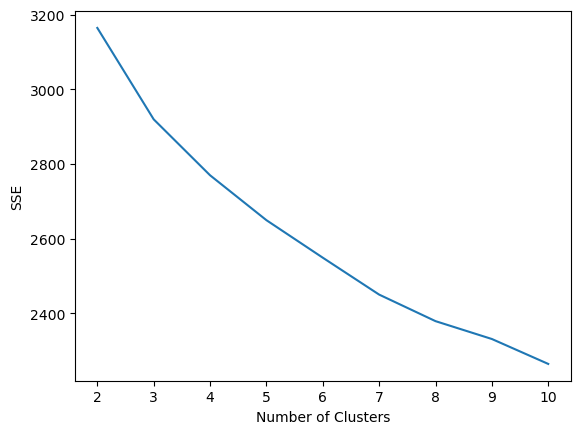

In [ ]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Silhouette coefficients

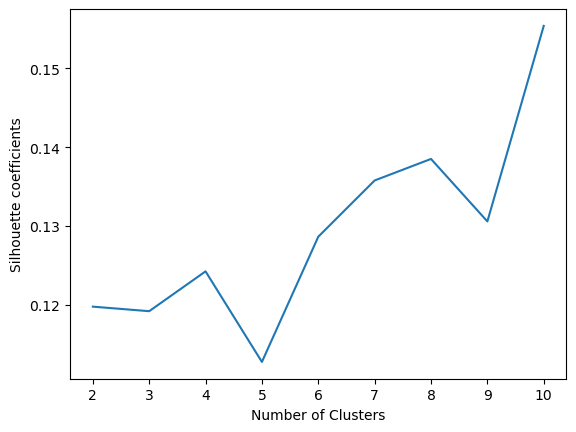

In [ ]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

In [42]:
# we label each anime to its designated cluster which will be used to generate recommendations
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
anime_clusters = kmeans.fit_predict(clustering_features)
anime_clusters_visual = kmeans.fit(clustering_features)

anime_with_clusters = anime_df.copy()
anime_with_clusters['Cluster'] = anime_clusters_visual.labels_

Identify the 2 features that have the highest correlation with each other to be used in the cluster plot

In [ ]:
# calculate the correlation matrix 
corr_matrix = clustering_features.corr(numeric_only=True)

# Set diagonal values to 0 as these indicate the correlation between the same features, i.e. members_norm, members_norm
np.fill_diagonal(corr_matrix.values, 0)

print(corr_matrix)

                 members_norm  avg_rating_norm  popularity_norm  \
members_norm         0.000000         0.392162        -0.440113   
avg_rating_norm      0.392162         0.000000        -0.662214   
popularity_norm     -0.440113        -0.662214         0.000000   
episodes_norm        0.052329         0.061119        -0.025479   
Action               0.161305         0.201747        -0.278705   
Adventure            0.034356         0.146583        -0.089508   
Cars                -0.017284        -0.030399         0.042728   
Comedy               0.076103         0.150812        -0.188875   
Dementia            -0.025593        -0.212343         0.110280   
Demons               0.041320         0.057726        -0.076380   
Drama                0.105827         0.241032        -0.153572   
Ecchi                0.096934         0.045705        -0.194566   
Fantasy              0.069107         0.125968        -0.107929   
Game                 0.039391         0.022041        -0.03656

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(clustering_features)

labels = kmeans.labels_

most_correlated = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
high_corr_pairs = most_correlated[most_correlated != 1][:2].reset_index()

feature1 = high_corr_pairs.iloc[0]['level_0']
feature2 = high_corr_pairs.iloc[0]['level_1']

print(f'Top pair of features: {feature1}, {feature2}')
print(f'Correlation coefficient: {corr_matrix.loc[feature1, feature2]}')

Top pair of features: avg_rating_norm, popularity_norm
Correlation coefficient: -0.6622142433907311


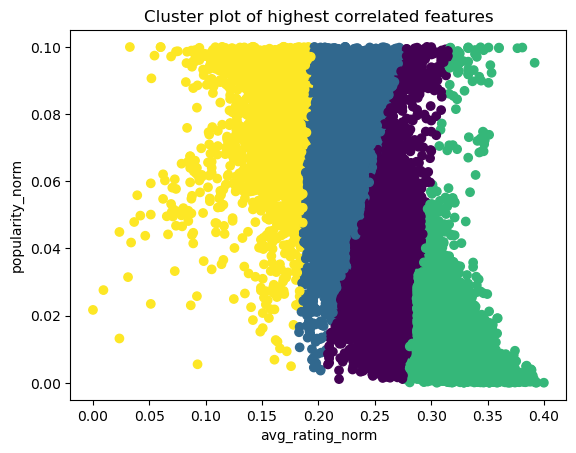

In [ ]:
X = clustering_features[[feature1, feature2]].values
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Cluster plot of highest correlated features')
plt.show()

In [43]:
def cluster_plot(data, nclusters):
    corr_matrix = data.corr(numeric_only=True)

    # Set diagonal values to 0 as these indicate the correlation between the same features, i.e. members_norm, members_norm
    np.fill_diagonal(corr_matrix.values, 0)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans.fit(data)

    labels = kmeans.labels_

    most_correlated = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
    high_corr_pairs = most_correlated[most_correlated != 1][:2].reset_index()

    feature1 = high_corr_pairs.iloc[0]['level_0']
    feature2 = high_corr_pairs.iloc[0]['level_1']


    X = clustering_features[[feature1, feature2]].values

    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X)

    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title('Cluster plot of highest correlated features')
    plt.show()


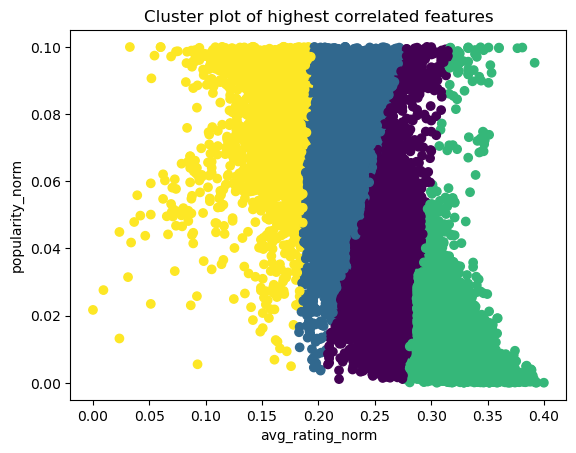

In [ ]:
clusters = clustering_features
cluster_plot(clusters, 4)

Get recommendations

In [44]:
def get_similar_anime(anime_name, data, n_recommendations=100):
    anime_index = anime_df[anime_df['name'] == anime_name].index[0]
    anime_cluster = data[anime_index]
    similar_anime_indexes = [i for i, cluster in enumerate(data) if cluster == anime_cluster and i != anime_index]
    similar_anime = anime_df.iloc[similar_anime_indexes]['name'].tolist()

    unique_titles = set(get_unique_recommendations(similar_anime))
    
    recommendations = [i for i in similar_anime if i in unique_titles]
    
    return recommendations[:n_recommendations+1]

In [ ]:
get_similar_anime('Death Note', anime_clusters)

['Shigatsu wa Kimi no Uso',
 'Sen to Chihiro no Kamikakushi',
 'Saraiya Goyou',
 'Byousoku 5 Centimeter',
 'Asagao to Kasesan',
 'Charlotte',
 'Capeta',
 'Hybrid Child',
 'Hello World',
 'Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu e TV',
 'The Everlasting Guilty Crown',
 'Tasogare Otome x Amnesia',
 'Colorful Movie',
 'Bishoujo Senshi Sailor Moon S',
 'Mariasama ga Miteru 3rd',
 'Planetarian Hoshi no Hito',
 'Eikoku Koi Monogatari Emma Moldershen',
 'Les Misérables Shoujo Cosette',
 'Coquelicotzaka kara',
 'Flanders no Inu Movie',
 'Touhai Densetsu Akagi Yami ni Maiorita Tensai',
 'Kyoukai no Kanata Movie Ill Be Here  Kakohen  Yakusoku no Kizuna',
 'Yumeiro Pâtissière',
 'Date A Live II Kurumi Star Festival',
 'Plastic Memories',
 'Jigoku Shoujo Futakomori',
 'Yagate Kimi ni Naru',
 'Takarajima',
 'Ie Naki Ko Remy',
 'Grisaia no Meikyuu Caprice no Mayu 0',
 'Fuichinsan',
 'Yuri on Ice Yuri Plisetsky GPF in Barcelona EX  Welcome to The Madness',
 'Luo Xiao Hei Zhan Ji Movie',
 'Hyoug

Clustering With PCA

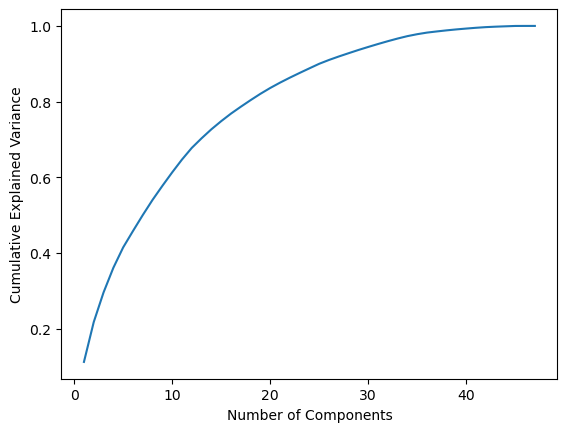

In [45]:
features = ['members_norm', 'avg_rating_norm', 'popularity_norm', 'episodes_norm'] + genres_df.columns.tolist()

selected_features_pca = normalised_anime_df[features].copy()
pca_anime_df = normalised_anime_df[features].copy()

pca = PCA().fit(pca_anime_df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [46]:
pca = PCA(n_components=30)
pca_result = pca.fit_transform(pca_anime_df)

# compute the number of clusters to use
sse = [] #sum of squared errors

# silhouette scores range from -1 to 1: 
# 1 = points are perfectly assigned in a clsuter and clusters are easily distinguishable
# 0 = clusters are overlapping
# -1 = points are wrongly assigned in a cluster

silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 10) #max_iter = 100
    kmeans.fit(pca_result)
    sse.append(kmeans.inertia_)

    ss = silhouette_score(pca_result, kmeans.labels_)
    silhouette_coefficients.append(ss)

print("SSE: ", sse)
print("Silhouette scores: ", silhouette_coefficients)

SSE:  [2968.689098817983, 2724.0655312093263, 2574.3792885482007, 2458.653341460539, 2351.0984111700714, 2271.9832213299132, 2203.3982010432287, 2101.7654978603905, 2038.5881915399902]
Silhouette scores:  [0.12650029607052737, 0.12747727692147404, 0.13258566598720645, 0.13311908696067015, 0.12985171535487844, 0.13341910725279493, 0.13798087117626479, 0.16882117840432315, 0.1773257453803446]


SSE With PCA

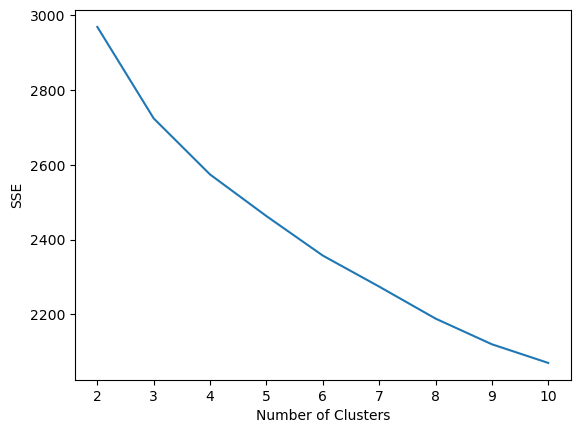

In [ ]:
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Silhouette Coefficients With PCA

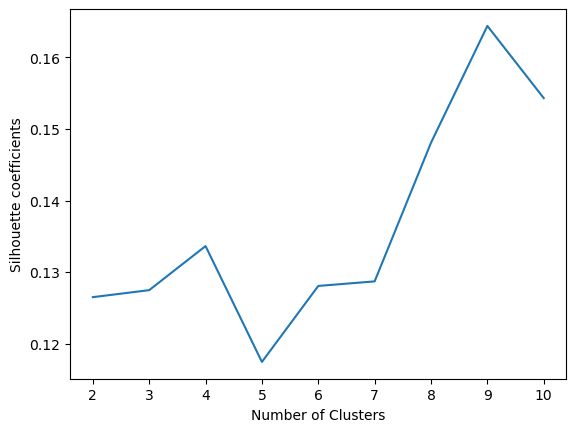

In [ ]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette coefficients")
plt.show()

Get recommendations using PCA

In [52]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(pca_result)
anime_clusters_after_pca = kmeans.predict(pca_result)

In [53]:
get_similar_anime('Death Note', anime_clusters_after_pca)

['Shigatsu wa Kimi no Uso',
 'Sen to Chihiro no Kamikakushi',
 'Saraiya Goyou',
 'Byousoku 5 Centimeter',
 'Asagao to Kasesan',
 'Charlotte',
 'Capeta',
 'Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu e TV',
 'The Everlasting Guilty Crown',
 'Tasogare Otome x Amnesia',
 'Colorful Movie',
 'Bishoujo Senshi Sailor Moon S',
 'Mariasama ga Miteru 3rd',
 'Eikoku Koi Monogatari Emma Moldershen',
 'Les Misérables Shoujo Cosette',
 'Coquelicotzaka kara',
 'Flanders no Inu Movie',
 'Touhai Densetsu Akagi Yami ni Maiorita Tensai',
 'Kyoukai no Kanata Movie Ill Be Here  Kakohen  Yakusoku no Kizuna',
 'Yumeiro Pâtissière',
 'Date A Live II Kurumi Star Festival',
 'Jigoku Shoujo Futakomori',
 'Yagate Kimi ni Naru',
 'Takarajima',
 'Ie Naki Ko Remy',
 'Grisaia no Meikyuu Caprice no Mayu 0',
 'Fuichinsan',
 'Yuri on Ice Yuri Plisetsky GPF in Barcelona EX  Welcome to The Madness',
 'Luo Xiao Hei Zhan Ji Movie',
 'Hyouge Mono',
 'Hikaru no Go Hokuto Hai e no Michi',
 'Rurouni Kenshin Meiji Kenkaku Roma

In [ ]:
def hybrid_recs_with_clustering(anime_name, data, content_weight=0.4, collaborative_weight=0.6, num_recommendations=20):
    if anime_name not in combined_category_ratings_pivot.index:
        return []

    content_based = get_similar_anime(anime_name, data)
    collaborative_filtering = collaborative_filtering_recommendations(anime_name)

    # removing anime titles that may no longer exist within our dataframe as some were removed after the initial
    # anime_df and ratings_df dataframes were merged together
    content_based_animes = []

    for i in content_based:
        if i in combined_category_ratings_pivot.index:
            content_based_animes.append(i)

    collaborative_based_animes = []

    for i in collaborative_filtering:
        if i in combined_category_ratings_pivot.index:
            collaborative_based_animes.append(i)

    content_based_scores = combined_category_ratings_pivot.loc[content_based_animes]
    collaborative_filtering_scores = combined_category_ratings_pivot.loc[collaborative_based_animes]

    # create weighted scores for all the animes using both the values generated from content based and collaborative filtering methods
    scores = content_based_scores.mul(content_weight).add(collaborative_filtering_scores.mul(collaborative_weight), fill_value=0)
    
    weighted_scores = scores[anime_name].sort_values(ascending=False)
    return weighted_scores, weighted_scores.head(num_recommendations).index.tolist()
    

In [ ]:
#Without PCA
hybrid_recs_with_clustering('One Punch Man', anime_clusters)[1]

['Tokyo Ghoul',
 'Noragami Aragoto',
 'Mob Psycho 100',
 'Boku no Hero Academia 2nd Season',
 'Samurai Champloo',
 'Kiseijuu Sei no Kakuritsu',
 'PsychoPass',
 'Young Black Jack',
 'Charlotte',
 'Gakusen Toshi Asterisk',
 'Gangsta',
 'Youjo Shenki Episode 0',
 'One Punch Man Specials',
 'Shokugeki no Souma',
 'Kill la Kill',
 'Ninja Senshi Tobikage',
 'Another',
 'Arslan Senki TV',
 'Chicchana Yukitsukai Sugar Specials',
 'Gakkougurashi']

In [ ]:
#With PCA
hybrid_recs_with_clustering('One Punch Man', anime_clusters_after_pca)[1]

['Tokyo Ghoul',
 'Mob Psycho 100',
 'Boku no Hero Academia 2nd Season',
 'Kiseijuu Sei no Kakuritsu',
 'PsychoPass',
 'Young Black Jack',
 'SteinsGate',
 'Charlotte',
 'Gakusen Toshi Asterisk',
 'Gangsta',
 'Youjo Shenki Episode 0',
 'One Punch Man Specials',
 'Shokugeki no Souma',
 'Kill la Kill',
 'Ninja Senshi Tobikage',
 'Another',
 'Arslan Senki TV',
 'Chicchana Yukitsukai Sugar Specials',
 'Gakkougurashi',
 'Accel World EX']

In [ ]:
def pca_cluster_plot(data, nclusters):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(data)

    kmeans = KMeans(n_clusters=nclusters, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    labels = kmeans.labels_

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-means Clustering with PCA using the top 2 Principal Components')
    plt.show()


With PCA

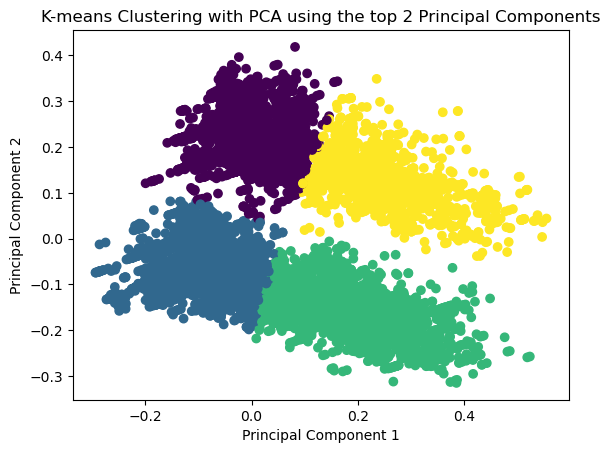

In [ ]:
pca_pd = pd.DataFrame(pca_result)
pca_cluster_plot(pca_pd, 4)

Without PCA

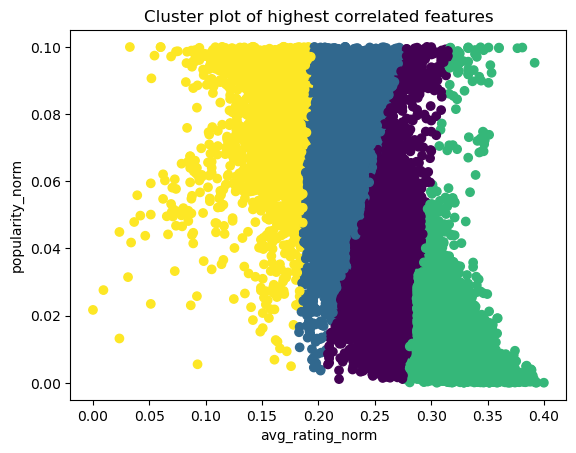

In [ ]:
clusters = clustering_features
cluster_plot(clusters, 4)

Performance

MAE (Mean Absolute Error)

Create dataframe to store the mean and standard deviation of all users

Gather information/data needed for the frontend

In [ ]:
def get_mean_and_std(user_id):
    user = user_ratings_df[user_ratings_df['user_id'] == user_id]

    user_mean = user['Overall'].mean()
    user_std = user['Overall'].std()

    return user_mean, user_std

In [ ]:
# for each user id in user_ratings_df['user_id'].unique(), get the mean 
# and standard deviation for that user

# create a dataframe from the results: user_id as index, mean and std as columns

user_mean_std = [get_mean_and_std(user_id) for user_id in user_ratings_df['user_id'].unique()]

user_mean_std_df = pd.DataFrame(user_mean_std, columns=['mean', 'std'])

user_mean_std_df.head()

In [ ]:
def calculate_mae(recommendations):
    # Create pivot table with users as rows and recommended anime as columns
    recommendations_pivot = recommendations.pivot_table(index='user_id', columns='anime_id', values='hybrid_score')
    
    # Merge pivot table with actual ratings data to get ratings for recommended anime
    ratings = pd.merge(mae_df, recommendations_pivot.stack().reset_index().rename(columns={0: 'hybrid_score'}), on=['user_id', 'anime_id'])
    ratings.drop(columns={'hybrid_score_x'}, inplace=True)
    ratings.rename(columns={'hybrid_score_y' : 'hybrid_score'}, inplace=True)
    ratings.drop_duplicates(subset=['user_id', 'anime_id'], inplace=True) 

    if not ratings['normalized_rating'].shape[0] > 1 or not ratings['hybrid_score'].shape[0] > 1:
        return None
    # Calculate MAE
    mae = mean_absolute_error(ratings['normalized_rating'], ratings['hybrid_score'])
    return mae

In [ ]:
def mae_value_without_clustering(title):
    
    # get the similarity scores of the hybrid recommendation titles
    hybrid_recommendations = combined_recommendations(title)[0]
    hybrid_recs_df = hybrid_recommendations.to_frame(name='hybrid_score')

    # Add anime ids to each of the recommendations so we can merge with anime_with_ratings_df 
    anime_indexes = [anime_df[anime_df['name'] == anime_name].index[0] for anime_name in hybrid_recs_df.index]
    anime_ids = [anime_df.loc[index, 'anime_id'] for index in anime_indexes]
    hybrid_recs_df['anime_id'] = anime_ids

    # Create our mae_df to be used specifically for MAE calculations
    mae_df = anime_with_ratings_df.copy()
    mae_df = pd.merge(anime_with_ratings_df, hybrid_recs_df, on='anime_id')
    mae_df[['Overall', 'Story', 'Animation', 'Character']] = mae_df[
    ['Overall', 'Story', 'Animation', 'Character']].apply(pd.to_numeric)

    # Add 'normalized_rating' column, which uses the Overall score a user has given an anime 
    # alongside the mean and standard deviation of all the animes a user has rated to normalise.
    mae_df['normalized_rating'] = mae_df.apply((lambda row: 
    (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'] 
    if user_mean_std_df.loc[row['user_id'], 'std'] != 0 else 0), axis=1)
    
    # NaN values are present as the user has only rated this single anime, so they 
    # are not that useful when providing recommendations, so we can simply just fill it with 0.
    mae_df['normalized_rating'] = mae_df['normalized_rating'].fillna(0)

    mae = calculate_mae(mae_df)

    return mae

In [ ]:
def mae_value_with_clustering(title):

    hybrid_recommendations = combined_recommendations_with_clustering(title)[0]
    hybrid_recs_df = hybrid_recommendations.to_frame(name='hybrid_score')

    anime_indexes = [anime_df[anime_df['name'] == anime_name].index[0] for anime_name in hybrid_recs_df.index]
    anime_ids = [anime_df.loc[index, 'anime_id'] for index in anime_indexes]

    hybrid_recs_df['anime_id'] = anime_ids

    mae_df = anime_with_ratings_df.copy()
    mae_df = pd.merge(anime_with_ratings_df, hybrid_recs_df, on='anime_id')

    mae_df[['Overall', 'Story', 'Animation', 'Character']] = mae_df[
    ['Overall', 'Story', 'Animation', 'Character']].apply(pd.to_numeric)

    mae_df['normalized_rating'] = mae_df.apply((lambda row: 
    (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'] 
    if user_mean_std_df.loc[row['user_id'], 'std'] != 0 else 0), axis=1)
    
    mae_df['normalized_rating'] = mae_df['normalized_rating'].fillna(0)

    mae = calculate_mae(mae_df)

    return mae

In [ ]:
def mae_value_with_clustering_and_pca(title):

    hybrid_recommendations = combined_recommendations_with_clustering_and_pca(title)[0]
    hybrid_recs_df = hybrid_recommendations.to_frame(name='hybrid_score')

    anime_indexes = [anime_df[anime_df['name'] == anime_name].index[0] for anime_name in hybrid_recs_df.index]
    anime_ids = [anime_df.loc[index, 'anime_id'] for index in anime_indexes]

    hybrid_recs_df['anime_id'] = anime_ids

    mae_df = anime_with_ratings_df.copy()
    mae_df = pd.merge(anime_with_ratings_df, hybrid_recs_df, on='anime_id')

    mae_df[['Overall', 'Story', 'Animation', 'Character']] = mae_df[
    ['Overall', 'Story', 'Animation', 'Character']].apply(pd.to_numeric)

    mae_df['normalized_rating'] = mae_df.apply((lambda row: 
    (row['Overall'] - user_mean_std_df.loc[row['user_id'], 'mean']) / user_mean_std_df.loc[row['user_id'], 'std'] 
    if user_mean_std_df.loc[row['user_id'], 'std'] != 0 else 0), axis=1)
    
    mae_df['normalized_rating'] = mae_df['normalized_rating'].fillna(0)


    mae = calculate_mae(mae_df)

    return mae

Calculating the MAE for every anime title would take a very long time, so we limit the number of titles to save us time.

MAE for Cosine Similarity Content-based filtering approach

In [ ]:
mae_values_without_clustering = [mae_value_without_clustering(title) for title in anime_with_ratings_df['name'].unique()[:100]]
mae_values_without_clustering = [i for i in mae_values_without_clustering if i is not None]

mae_mean_without_clustering = statistics.mean(mae_values_without_clustering)

mae_mean_without_clustering

MAE for Clustering without PCA Content-based filtering approach

In [ ]:
mae_values_with_clustering = [mae_value_with_clustering(title) for title in anime_with_ratings_df['name'].unique()[:100]]
mae_values_with_clustering = [i for i in mae_values_with_clustering if i is not None]

mae_mean_with_clustering = statistics.mean(mae_values_with_clustering)

mae_mean_with_clustering

MAE for Clustering with PCA Content-based filtering approach

In [ ]:
mae_values_with_pca = [mae_value_with_clustering_and_pca(title) for title in anime_with_ratings_df['name'].unique()[:100]]
mae_values_with_pca = [i for i in mae_values_with_pca if i is not None]

mae_mean_with_pca = statistics.mean(mae_values_with_pca)

mae_mean_with_pca

Coverage Testing

Coverage Testing -> Cosine Similarity Content-based filtering approach

In [80]:
all_anime_titles = list(anime_with_ratings_df['name'].unique())

# set to store all recommended anime titles
recommended_anime = set()

for anime_title in all_anime_titles:
    recommendations = combined_recommendations(anime_title)[1]
    for recommendation in recommendations:
        recommended_anime.add(recommendation)

coverage = (len(recommended_anime) / len(anime_df['name'])) * 100

print(f"Coverage: {coverage:.2f}%")
# Coverage: 60.65% testing all anime titles -> 15mins 

Coverage: 47.07%


Coverage Testing -> K-means clustering Content-based filtering approach

In [81]:
all_anime_titles = list(anime_with_ratings_df['name'].unique()[:10])

# set to store all recommended anime titles
recommended_anime = set()

for anime_title in all_anime_titles:
    recommendations = combined_recommendations_with_clustering(anime_title)[1]
    for recommendation in recommendations:
        recommended_anime.add(recommendation)

clustering_coverage = (len(recommended_anime) / len(anime_df['name'])) * 100

print(f"Clustering Coverage: {clustering_coverage:.2f}%")

Clustering Coverage: 1.14%


Coverage Testing -> K-means clustering with PCA Content-based filtering approach

In [82]:
all_anime_titles = list(anime_with_ratings_df['name'].unique())

# set to store all recommended anime titles
recommended_anime = set()

for anime_title in all_anime_titles:
    recommendations = combined_recommendations_with_clustering_and_pca(anime_title)[1]
    for recommendation in recommendations:
        recommended_anime.add(recommendation)

pca_coverage = (len(recommended_anime) / len(anime_df['name'])) * 100

print(f"Clustering with PCA Coverage: {pca_coverage:.2f}%")

KeyboardInterrupt: 

Website related functions

In [ ]:
recommendations = combined_recommendations('Death Note')[1]

recommendations

['Monster',
 'Another',
 'Mirai Nikki',
 'Death Parade',
 'Mousou Dairinin',
 'Shiki',
 'Fullmetal Alchemist Brotherhood',
 'Gankutsuou',
 'Higurashi no Naku Koro ni Kai',
 'Code Geass Hangyaku no Lelouch R2',
 'Sword Art Online',
 'SteinsGate',
 'Elfen Lied',
 'Cowboy Bebop',
 'Deadman Wonderland',
 'Ouran Koukou Host Club',
 'Clannad After Story',
 'Highschool of the Dead',
 'Sen to Chihiro no Kamikakushi',
 'Ansatsu Kyoushitsu']

Retrieve Anime IDs (MAL ID) for all the recommendations to help fetch and display them using Jikan API on the website

In [ ]:
def get_ids_for_recommendations(recommendations):

    anime_ids = []
    for rec in recommendations:
        id = anime_df.loc[anime_df['name'] == rec]['anime_id'].values[0]
        anime_ids.append(id)

    return anime_ids

In [ ]:
ids = get_ids_for_recommendations(recommendations)

ids

[19,
 11111,
 10620,
 28223,
 323,
 7724,
 5114,
 239,
 1889,
 2904,
 11757,
 9253,
 226,
 1,
 6880,
 853,
 4181,
 8074,
 199,
 24833]

In [ ]:
recommendation_ids_df = pd.DataFrame(ids, columns=['mal_id'])

recommendation_ids_df.head()

,mal_id
0,19
1,11111
2,10620
3,28223
4,323


Restoring original anime_df to use columns dropped for recommendation purposes as information to be passed to the frontend

In [ ]:
def get_website_anime_df():
    website_anime_df = pd.read_csv("datasets/animes.csv")

    # reformat dataframe: removing NaN values and renaming columns, etc.
    website_anime_df.rename(columns={'title': 'name'}, inplace=True)
    
    website_anime_df['name'] = website_anime_df['name'].apply(text_cleaning)

    website_anime_df.rename(columns={'uid': 'anime_id', 'score': 'rating'}, inplace=True)
    website_anime_df.episodes.replace({'Unknown':np.nan},inplace=True)

    # fill NaN values for images with a default MAL picture:
    website_anime_df.fillna('https://image.myanimelist.net/ui/OK6W_koKDTOqqqLDbIoPAiC8a86sHufn_jOI-JGtoCQ', inplace=True)

    website_anime_df.drop_duplicates(subset=['name'], inplace=True)
    website_anime_df.dropna(inplace=True)
    website_anime_df.reset_index(drop=True, inplace=True)

    # replace the characters "[]'" with an empty space as the genre column is already of type string
    website_anime_df['genre'] = website_anime_df['genre'].str.replace("'", "", regex=False)
    website_anime_df['genre'] = website_anime_df['genre'].str.replace("[", "", regex=False)
    website_anime_df['genre'] = website_anime_df['genre'].str.replace("]", "", regex=False)

    return website_anime_df

In [ ]:
website_anime_df = get_website_anime_df()

website_anime_df.head()

,anime_id,name,synopsis,genre,aired,episodes,members,popularity,ranked,rating,img_url,link
0,28891,Haikyuu Second Season,Following their participation at the Inter-Hig...,"Comedy, Sports, Drama, School, Shounen","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"Drama, Music, Romance, School, Shounen","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"Sci-Fi, Adventure, Mystery, Drama, Fantasy","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III Reiketsuhen,After helping revive the legendary vampire Kis...,"Action, Mystery, Supernatural, Vampire","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


Gathering only the rows which are produced from the recommendations

In [ ]:
website_recommendations_df = website_anime_df[website_anime_df['name'].isin(recommendations)] 
website_recommendations_df.reset_index(drop=True, inplace=True)

website_recommendations_df.head(10)

,anime_id,name,synopsis,genre,aired,episodes,members,popularity,ranked,rating,img_url,link
0,5114,Fullmetal Alchemist Brotherhood,"""In order for something to be obtained, someth...","Action, Military, Adventure, Comedy, Drama, Ma...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
1,199,Sen to Chihiro no Kamikakushi,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Adventure, Supernatural, Drama","Jul 20, 2001",1.0,913212,40,20.0,8.9,https://cdn.myanimelist.net/images/anime/6/795...,https://myanimelist.net/anime/199/Sen_to_Chihi...
2,2904,Code Geass Hangyaku no Lelouch R2,"One year has passed since the Black Rebellion,...","Action, Military, Sci-Fi, Super Power, Drama, ...","Apr 6, 2008 to Sep 28, 2008",25.0,992196,27,17.0,8.93,https://cdn.myanimelist.net/images/anime/4/939...,https://myanimelist.net/anime/2904/Code_Geass_...
3,4181,Clannad After Story,"Clannad: After Story , the sequel to the criti...","Slice of Life, Comedy, Supernatural, Drama, Ro...","Oct 3, 2008 to Mar 27, 2009",24.0,740101,64,12.0,8.97,https://cdn.myanimelist.net/images/anime/13/24...,https://myanimelist.net/anime/4181/Clannad__Af...
4,239,Gankutsuou,"In the year 5053, French aristocrats Viscount ...","Drama, Mystery, Sci-Fi, Supernatural, Thriller","Oct 6, 2004 to Mar 30, 2005",24.0,164454,671,357.0,8.17,https://cdn.myanimelist.net/images/anime/10/22...,https://myanimelist.net/anime/239/Gankutsuou
5,24833,Ansatsu Kyoushitsu,When a mysterious creature chops the moon down...,"Action, Comedy, School, Shounen","Jan 10, 2015 to Jun 20, 2015",22.0,827723,54,324.0,8.19,https://cdn.myanimelist.net/images/anime/5/756...,https://myanimelist.net/anime/24833/Ansatsu_Ky...
6,28223,Death Parade,"After death, there is no heaven or hell, only ...","Game, Mystery, Psychological, Drama, Thriller","Jan 10, 2015 to Mar 28, 2015",12.0,864345,47,308.0,8.22,https://cdn.myanimelist.net/images/anime/5/715...,https://myanimelist.net/anime/28223/Death_Parade
7,853,Ouran Koukou Host Club,Haruhi Fujioka is a bright scholarship candida...,"Comedy, Harem, Romance, School, Shoujo","Apr 5, 2006 to Sep 27, 2006",26.0,641087,83,253.0,8.28,https://cdn.myanimelist.net/images/anime/2/719...,https://myanimelist.net/anime/853/Ouran_Koukou...
8,1889,Higurashi no Naku Koro ni Kai,"In the small village of Hinamizawa, Rika Furud...","Mystery, Psychological, Supernatural, Thriller","Jul 6, 2007 to Dec 18, 2007",24.0,317911,306,238.0,8.29,https://cdn.myanimelist.net/images/anime/12/14...,https://myanimelist.net/anime/1889/Higurashi_n...
9,19,Monster,"Dr. Kenzou Tenma, an elite neurosurgeon recent...","Drama, Horror, Mystery, Police, Psychological,...","Apr 7, 2004 to Sep 28, 2005",74.0,459710,159,46.0,8.69,https://cdn.myanimelist.net/images/anime/10/18...,https://myanimelist.net/anime/19/Monster


Function to gather and return the required data to the frontend

In [ ]:
def get_data_for_recommendations(recommendations):
    global website_anime_df

    # recommendations = request.args.get('query')
    recommendations = recommendations.replace('%20', ' ')
    recommendations = recommendations.split(',')

    website_recommendations_df = website_anime_df[website_anime_df['name'].isin(recommendations)] 

    anime_ids = []
    img_urls = []
    mal_link = []
    status = 200

    for rec in recommendations:
        anime_rec = website_recommendations_df.loc[website_recommendations_df['name'] == rec]
        anime_ids.append(int(anime_rec['anime_id'].values[0]))
        img_urls.append(str(anime_rec['img_url'].values[0]))
        mal_link.append(str(anime_rec['link'].values[0]))

    return anime_ids, img_urls, mal_link, status